## Why is the tracer on the canyon box wrong?


In [1]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

#from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
#lib_path = os.path.abspath('../BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts

sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import MetricsPythonTools as mpt 

In [3]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')

In [10]:
#Exp
#CGrid = '/Users/Karina/Research/PhD/Tracers/TemporaryData/BARKLEY/run01/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run06/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CPtracers = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run06/ptracersGlob.nc' # Smallest volume grid, closed bdy, no canyon.

CGridOut = Dataset(CGrid)


In [5]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 3 # number of tracers in run

rc = CGridOut.variables['RC']

xc = rout.getField(CGrid, 'XC') # x coords tracer cells
yc = rout.getField(CGrid, 'YC') # y coords tracer cells

drF = CGridOut.variables['drF'] # vertical distance between faces
drC = CGridOut.variables['drC'] # vertical distance between centers

labels = ['Linear','Salt','Oxygen','Nitrate','Silicate','Phosphate','Nit. Acid','Methane']

#print(drC[:])
#print(np.shape(drC))

In [6]:
def get_iniProfile(exp, run, TrNum, key):
    '''Get column from the pandas dataframe containing initial profiles using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI), TrNum (1,2,3, etc). All input variables are strings.
    Returns the desired column from the dataframe.'''
    df = pd.read_csv(('results/metricsDataFrames/%srun%siniTr%s.csv' %(exp,run,TrNum)))
    col = df[key]
    return col

def get_metrics(exp, run, TrNum, key):
    '''Get column from a tracer metrics pandas dataframe using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI). All input variables are strings. Returns the desired column from the dataframe'''
    df = pd.read_csv(('results/metricsDataFrames/%srun%sTr%s.csv' %(exp,run,TrNum)))
    col = df[key]
    return col


# load initial profiles

tracers = ['1','2','3','4','5','6','7','8']

IniP = np.zeros((nz,len(tracers))) 
TotalTr = np.zeros((nt,len(tracers))) 
TotalHCW = np.zeros((nt,len(tracers)))
TotalTrNoC = np.zeros((nt,len(tracers))) 
TotalHCWNoC = np.zeros((nt,len(tracers))) 
TotalTrHole = np.zeros((nt,len(tracers))) 
TotalHCWHole = np.zeros((nt,len(tracers)))
TotalTrHoleNoC = np.zeros((nt,len(tracers))) 
TotalHCWHoleNoC = np.zeros((nt,len(tracers))) 

TotalTrSh = np.zeros((nt,len(tracers))) 
TotalHCWSh = np.zeros((nt,len(tracers)))
TotalTrShNoC = np.zeros((nt,len(tracers))) 
TotalHCWShNoC = np.zeros((nt,len(tracers))) 
TotalNoC = np.zeros((nt,len(tracers)))
TotalWatNoC = np.zeros((nt,len(tracers)))

kk = 0

for ii in tracers:
    
    IniP[:,kk] = get_iniProfile('BAR', '01', ii,'IniProfile' )
    #TotalTr[:,kk] = get_metrics('BAR_hole_NoCMask_', '01', ii,'TronShelfwHole' ) # Shelf box
    #TotalHCW[:,kk] = get_metrics('BAR_hole_NoCMask_', '01', ii,'HCWonShelfwHole' ) 
    #TotalTrHole[:,kk] = get_metrics('BAR_hole_NoCMask_', '01', ii,'TronHole' ) # Canyon box
    #TotalHCWHole[:,kk] = get_metrics('BAR_hole_NoCMask_', '01', ii,'HCWonHole' )
    
    
    TotalTrNoC[:,kk] = get_metrics('BAR_hole_NoCMask_', '02', ii,'TronShelfwHole' ) # Shelf box no canyon
    TotalHCWNoC[:,kk] = get_metrics('BAR_hole_NoCMask_', '02', ii,'HCWonShelfwHole' )
    TotalTrHoleNoC[:,kk] = get_metrics('BAR_hole_NoCMask_', '02', ii,'TronHole' ) # canyon box no canyon
    TotalHCWHoleNoC[:,kk] = get_metrics('BAR_hole_NoCMask_', '02', ii,'HCWonHole' )
    
    TotalNoC[:,kk] = get_metrics('BAR', '02', ii,'TronShelf' ) # complete shelf no canyon
    TotalWatNoC[:,kk] = get_metrics('BAR', '02', ii,'HCWonShelf' )
    
    
    kk=kk+1


TotalTrSh = TotalTr + TotalTrHole
TotalTrShNoC = TotalTrNoC + TotalTrHoleNoC
TotalHCWSh = TotalHCW + TotalHCWHole
TotalHCWShNoC = TotalHCWNoC + TotalHCWHoleNoC
        

In [11]:
Tr1 = rout.getField(CPtracers, 'Tr1')
Tr2 = rout.getField(CPtracers,'Tr2')
Tr3 = rout.getField(CPtracers,'Tr3')
#Tr7 = rout.getField(CPtracers,'Tr07')

#---------------------------------------------------------------------------------------------------------------------------
def howMuchWaterShwHole(Tr,MaskC,nzlim,rA,hFacC,drF,yin,zfin,xi,yi,xh1=120,xh2=240,yh1=227,yh2=267):
  '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    xh1=120 : 1st x index of hole (defaults are the definitions used for transport calculations)
    xh2=240 : 2nd x index of hole
    yh1=227 : 1st y index of hole
    yh2=267 : 2nd y index of hole
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [:,:30,227:,:] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [:,:30,227:,:] at 
                    every time output. Total mass of tracer at xx on the shelf.
    VolWaterHighConcHole =  Array with the volume of water insde cube at every time output.
    Total_TracerHole =  Array with the mass of tracer inside hole.
                                               
    -----------------------------------------------------------------------------------------------------------------------
  '''
  maskExp = maskExpand(MaskC,Tr)

  TrMask=np.ma.array(Tr,mask=maskExp)   
    
  trlim = TrMask[0,nzlim,yi,xi]
    
  print('tracer limit concentration is: ',trlim)
    
  
  # mask cells with tracer concentration < trlim on control volume
  HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
  HighConc_Mask = HighConc_Masked.mask
    
  HighConcHole_Masked = np.ma.masked_less(TrMask[:,:zfin,yh1:yh2,xh1:xh2], trlim) 
  HighConcHole_Mask = HighConcHole_Masked.mask
  
  
  #Get volume of water of cells with relatively high concentration
  rA_exp = np.expand_dims(rA[yin:,:],0)
  rA_exp_hole = np.expand_dims(rA[yh1:yh2,xh1:xh2],0)
  
  rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
  rA_exp_hole = rA_exp_hole + np.zeros(hFacC[:zfin,yh1:yh2,xh1:xh2].shape)
 
  drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  drF_exp_hole = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  
  drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
  drF_exp_hole = drF_exp_hole +np.zeros(hFacC[:zfin,yh1:yh2,xh1:xh2].shape)
  
   
  ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
  ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
  ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
  HoleVolume = hFacC[:zfin,yh1:yh2,xh1:xh2]*drF_exp_hole*rA_exp_hole
  HoleVolume_exp = np.expand_dims(HoleVolume,0)
  HoleVolume_exp = HoleVolume_exp + np.zeros(HighConcHole_Mask.shape)
  
  
  HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
  HighConc_CellVol_Hole = np.ma.masked_array(HoleVolume_exp,mask = HighConcHole_Mask) 
  
  VolWaterHighConc = np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1),axis=1)
  VolWaterHighConcHole = np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol_Hole,axis = 1),axis=1),axis=1)
  
  VolWaterHighConcShelfwHole = VolWaterHighConc-VolWaterHighConcHole
  
  #Get total mass of tracer on shelf
  Total_Tracer = np.ma.sum(np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1),axis=1) 
  Total_Tracer_Hole = np.ma.sum(np.ma.sum(np.ma.sum(HoleVolume_exp*TrMask[:,:zfin,yh1:yh2,xh1:xh2]*1000.0,axis = 1),axis=1),axis=1) 
  
  Total_Tracer_ShelfwHole = Total_Tracer-Total_Tracer_Hole
  
  # 1 m^3 = 1000 l
    
  return (VolWaterHighConcShelfwHole, Total_Tracer_ShelfwHole,VolWaterHighConcHole,Total_Tracer_Hole)

In [13]:
Tr=Tr2

hFacC = rout.getField(CGrid, 'HFacC')
MaskC = rout.getMask(CGrid, 'HFacC')
nzlim = 30
rA = rout.getField(CGrid, 'rA')
yin = 227
zfin = 30
xi = 180
yi = 50
xh1=120
xh2=240
yh1=227
yh2=267

maskExp = mpt.maskExpand(MaskC,Tr)

TrMask=np.ma.array(Tr,mask=maskExp)   
    
trlim = TrMask[0,nzlim,yi,xi]
    
print('tracer limit concentration is: ',trlim)
    
  
# mask cells with tracer concentration < trlim on control volume
HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
HighConc_Mask = HighConc_Masked.mask
    
HighConcHole_Masked = np.ma.masked_less(TrMask[:,:zfin,yh1:yh2,xh1:xh2], trlim) 
HighConcHole_Mask = HighConcHole_Masked.mask
  
  
#Get volume of water of cells with relatively high concentration
rA_exp = np.expand_dims(rA[yin:,:],0)
rA_exp_hole = np.expand_dims(rA[yh1:yh2,xh1:xh2],0)
  
rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
rA_exp_hole = rA_exp_hole + np.zeros(hFacC[:zfin,yh1:yh2,xh1:xh2].shape)
 
drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
drF_exp_hole = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  
drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
drF_exp_hole = drF_exp_hole +np.zeros(hFacC[:zfin,yh1:yh2,xh1:xh2].shape)
  
   
ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
HoleVolume = hFacC[:zfin,yh1:yh2,xh1:xh2]*drF_exp_hole*rA_exp_hole
HoleVolume_exp = np.expand_dims(HoleVolume,0)
HoleVolume_exp = HoleVolume_exp + np.zeros(HighConcHole_Mask.shape)
  
  
HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
HighConc_CellVol_Hole = np.ma.masked_array(HoleVolume_exp,mask = HighConcHole_Mask) 
  
VolWaterHighConc = np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1),axis=1)
VolWaterHighConcHole = np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol_Hole,axis = 1),axis=1),axis=1)
  
VolWaterHighConcShelfwHole = VolWaterHighConc-VolWaterHighConcHole
  
#Get total mass of tracer on shelf
Total_Tracer = np.ma.sum(np.ma.sum(np.ma.sum(TrMask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1),axis=1) 
Total_Tracer_Hole = np.ma.sum(np.ma.sum(np.ma.sum(TrMask[:,:zfin,yh1:yh2,xh1:xh2]*1000.0,axis = 1),axis=1),axis=1) 
  
Total_Tracer_ShelfwHole = Total_Tracer-Total_Tracer_Hole
  
# 1 m^3 = 1000 l
    


('tracer limit concentration is: ', 7.3974895)


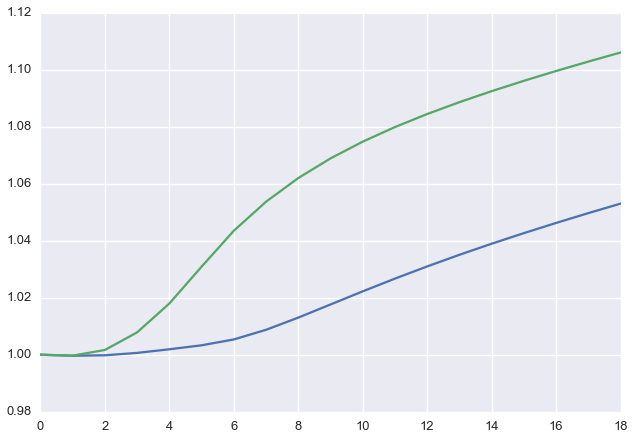

In [14]:
plt.plot(Total_Tracer_Hole/Total_Tracer_Hole[0])
plt.plot(Total_Tracer/Total_Tracer[0])

In [15]:
depth = rout.getField(CGrid, 'Depth')

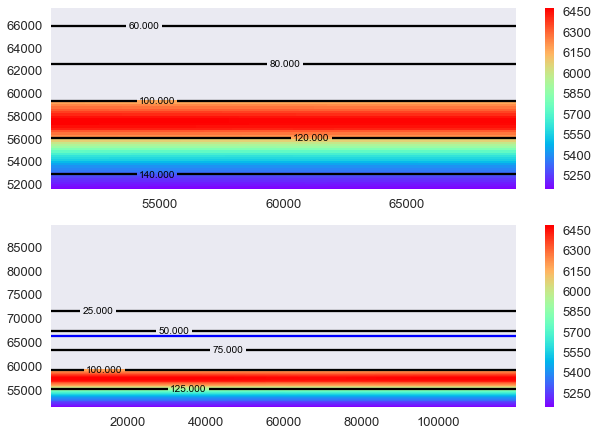

In [16]:
HH =TrMask[:,:zfin,yh1:300,xh1:xh2]*1000.0
SS = TrMask[:,:zfin,yin:,:]*1000.0

plt.subplot(2,1,1)

cs = plt.contour(xc[yh1:300,xh1:xh2],yc[yh1:300,xh1:xh2],depth[yh1:300,xh1:xh2], 5,colors = 'k')
plt.clabel(cs, inline=1, fontsize=10)

plt.pcolor(xc[yh1:300,xh1:xh2],yc[yh1:300,xh1:xh2],HH[5,20,:,:],cmap='rainbow')
plt.colorbar()

plt.subplot(2,1,2)

cs = plt.contour(xc[yin:,:],yc[yin:,:],depth[yin:,:], 5,colors = 'k')
plt.clabel(cs, inline=1, fontsize=10)

plt.pcolor(xc[yin:,:],yc[yin:,:],SS[5,20,:,:],cmap='rainbow')
plt.colorbar()

plt.axhline(y=yc[295,1])

In [17]:
TT= np.sum(np.sum(TrMask[:,:zfin,yin:,:]*1000.0,axis=2),axis=2) 
TThole= np.sum(np.sum(TrMask[:,:zfin,yh1:yh2,xh1:xh2]*1000.0,axis=2),axis=2) 


<matplotlib.colorbar.Colorbar instance at 0x7f47600a8dd0>

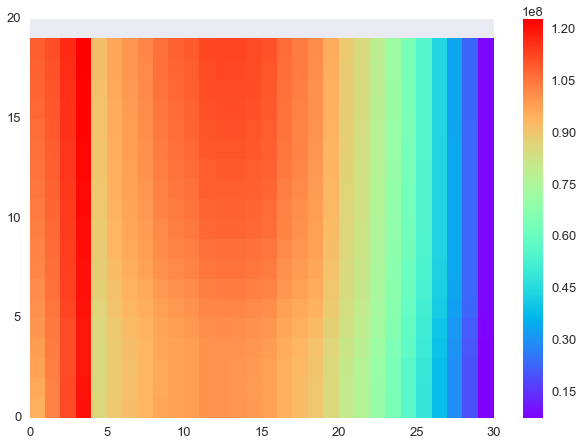

In [18]:
plt.pcolor(TT, cmap = 'rainbow')
plt.colorbar()


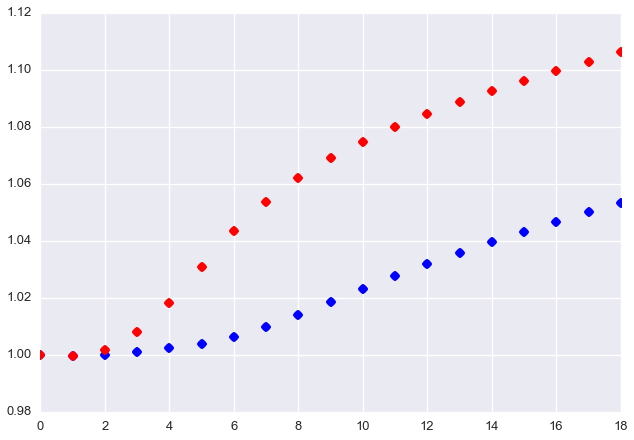

In [24]:
for tt in range(19):
    plt.plot(tt,np.sum(TrMask[tt,:zfin,227:267,:])/np.sum(TrMask[0,:zfin,227:267,:]),'bo')
    plt.plot(tt,np.sum(TrMask[tt,:zfin,227:,:])/np.sum(TrMask[0,:zfin,227:,:]),'ro')
    

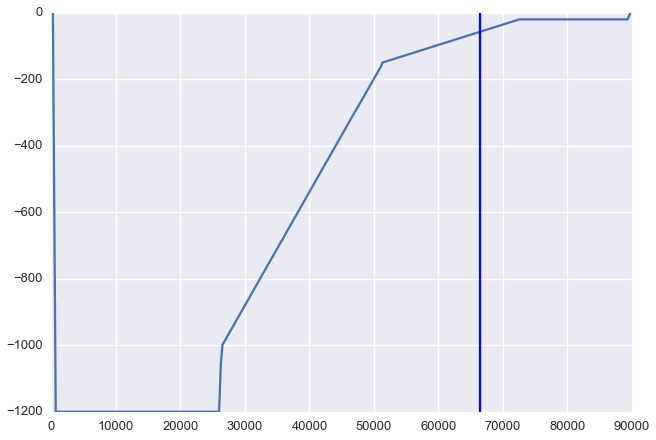

In [20]:
plt.plot(yc[:,180],-depth[:,180])
plt.axvline(x=yc[295,180])